### Libraries import

In [ ]:
import csv
import math
import numpy as np
import pandas as pd
import random as rd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection

###Spread function

In [ ]:
# Set parametrization for the cellular automaton
size = (50, 50)
number_of_days = 10000
crit = 4
matrix_orig = [[[0 for x in range(size[1]+2)] for y in range(size[0]+2)] for z in range(number_of_days)]
new_grains = []
for d in range(0, number_of_days):
  grain = [np.random.randint(1, size[0]+1), np.random.randint(1, size[1]+1)]
  new_grains.append(grain)

In [ ]:
# Set additional parametrization in case of higher dissipation from the system
new_grains_plus = []
new_grains_minus = []
for d in range(0, number_of_days):
  grain_plus = [np.random.randint(1, size[0]+1), np.random.randint(1, size[1]+1)]
  new_grains_plus.append(grain_plus)

  grain_minus = [np.random.randint(1, size[0]+1), np.random.randint(1, size[1]+1)]
  new_grains_minus.append(grain_minus)

In [ ]:
# Function for calculation of number of sand grains in and out of the model
def counter(matrix, d):
  inner_d = 0
  outer_d = 0

  for i in range(1, len(matrix[0])-1):
    for j in range(1, len(matrix[0][0])-1):
      inner_d += matrix[d][i][j]
  
  outer_d = d - inner_d + 1

  return inner_d, outer_d

In [ ]:
# Function for modelling of spread for Bak-Tang-Wiesenfeld, Manna, Feders
# and stochastic Feders base and facilitated models on cellular automatons.
# Also there is a possibility to change the regime of the system from +1 
# each turn to +2-1, which partially changes behaviour of the system.
def spread(model:str, 
           matrix, 
           number_of_days:int, 
           new_grains:list, 
           facilitated:bool = False, 
           ad_dissipation:bool = False, 
           new_grains_plus:list = None,
           new_grains_minus: list = None, 
           crit = 4):

  inner = []
  outer = []
  falls = []

  if facilitated == True:
    facilit_matrix = [[[0 for x in range(size[1]+2)] for y in range(size[0]+2)] for z in range(number_of_days)]

  for d in tqdm(range(0, len(matrix))):
    falls_d = 0
    matrix[d][new_grains[d][0]][new_grains[d][1]] += 1
    if ad_dissipation == True:
      matrix[d][new_grains_plus[d][0]][new_grains_plus[d][1]] += 1
      matrix[d][new_grains_minus[d][0]][new_grains_minus[d][1]] -= 1
    for i in range(0, len(matrix[0])):
      for j in range(0, len(matrix[0][0])):
        if d<=(len(matrix)-2):
          matrix[d+1][i][j] += matrix[d][i][j]
    for i in range(0, len(matrix[0])):
      for j in range(0, len(matrix[0][0])):
        if facilitated == False:
          if d<=(len(matrix)-2) and 1<=i<=(len(matrix[0])-2) and 1<=j<=(len(matrix[0][0])-2) and matrix[d][i][j] >= crit:
            if model == "BTW":
              matrix, falls_d = BTW(matrix, falls_d, d, i, j, crit)
            if model == "MA":
              matrix, falls_d = MA(matrix, falls_d, d, i, j, crit)
            if model == "FE":
              matrix, falls_d = FE(matrix, falls_d, d, i, j, crit)    
            if model == "SFE":
              matrix, falls_d = SFE(matrix, falls_d, d, i, j, crit)
        else:
          if d<=(len(matrix)-2) and 1<=i<=(len(matrix[0])-2) and 1<=j<=(len(matrix[0][0])-2) and (matrix[d][i][j] >= crit or facilit_matrix[d][i][j] >= 2):
            if model == "BTW":
              matrix, facilit_matrix, falls_d = BTW_fa(matrix, facilit_matrix, falls_d, d, i, j, crit)
            if model == "MA":
              matrix, facilit_matrix, falls_d = MA_fa(matrix, facilit_matrix, falls_d, d, i, j, crit)
            if model == "FE":
              matrix, facilit_matrix, falls_d = FE_fa(matrix, facilit_matrix, falls_d, d, i, j, crit)    
            if model == "SFE":
              matrix, facilit_matrix, falls_d = SFE_fa(matrix, facilit_matrix, falls_d, d, i, j, crit)

    inner_d, outer_d = counter(matrix, d)
    inner.append(inner_d)
    outer.append(outer_d)
    if d <= len(matrix)-2:
      falls.append(falls_d)

  for d in range(0, len(matrix)):
    for i in range(0, len(matrix[0])):
      for j in range(0, len(matrix[0][0])):
        matrix[d][i][j] = 0

  print(inner)
  print(outer)
  print(falls)
  data = pd.DataFrame(falls)
  ca_name = model
  if facilitated == True: 
    ca_name = ca_name + '_fa'
  if ad_dissipation == True: 
    ca_name = ca_name + '_ad'

  data.to_csv('CA_SOC/' + ca_name + '.csv', index=False)

  fig, axs = plt.subplots(2, 1, figsize=(15, 10))
  axs[0].xaxis.get_major_locator().set_params(integer=True)
  axs[0].yaxis.get_major_locator().set_params(integer=True)
  axs[1].xaxis.get_major_locator().set_params(integer=True)
  axs[1].yaxis.get_major_locator().set_params(integer=True)
  axs[0].set(ylim=(0, 10000))
  axs[1].set(ylim=(0, 200))
  axs[0].plot(list(range(number_of_days)), inner, color='#40a6d1', alpha = 0.5, label = "Inner Grains")
  axs[0].plot(list(range(number_of_days)), outer, color='red', alpha = 0.5, label = "Outer Grains")
  axs[0].legend(loc = 'upper right', fontsize='medium')
  axs[0].set_title('Number of grains in and out of the ' + ca_name + ' model')
  axs[1].plot(list(range(number_of_days-1)), falls, color='#40a6d1', alpha = 0.5)
  axs[1].set_title('Number of falls in the ' + ca_name + ' model')
  plt.setp(axs[0], xlabel='Day', ylabel='Grains')
  plt.setp(axs[1], xlabel='Day', ylabel='Falls')
  plt.tight_layout()
  plt.show()

### Model definition

In [ ]:
def BTW(matrix, falls_d, d, i, j, crit):
  falls_d += 1
  matrix[d+1][i-1][j] += 1
  matrix[d+1][i+1][j] += 1
  matrix[d+1][i][j-1] += 1
  matrix[d+1][i][j+1] += 1
  matrix[d+1][i][j] -= crit

  return matrix, falls_d

In [ ]:
def BTW_fa(matrix, facilit_matrix, falls_d, d, i, j, crit):
  falls_d += 1
  if matrix[d][i][j] >= crit:
    matrix[d+1][i-1][j] += 1
    matrix[d+1][i+1][j] += 1
    matrix[d+1][i][j-1] += 1
    matrix[d+1][i][j+1] += 1
    matrix[d+1][i][j] -= crit
    facilit_matrix[d+1][i-1][j] += 1
    facilit_matrix[d+1][i+1][j] += 1
    facilit_matrix[d+1][i][j-1] += 1
    facilit_matrix[d+1][i][j+1] += 1
  elif matrix[d][i][j] < crit and matrix[d][i][j] > 0:
    n_1 = rd.randint(0, matrix[d][i][j])
    n_2 = rd.randint(0, matrix[d][i][j]-n_1)
    n_3 = rd.randint(0, matrix[d][i][j]-n_1-n_2)
    n_4 = matrix[d][i][j] - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= matrix[d][i][j]
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1

  return matrix, facilit_matrix, falls_d

In [ ]:
def MA(matrix, falls_d, d, i, j, crit):
  falls_d += 1
  n_1 = rd.randint(0, crit)
  n_2 = rd.randint(0, crit-n_1)
  n_3 = rd.randint(0, crit-n_1-n_2)
  n_4 = crit - n_1 - n_2 - n_3
  matrix[d+1][i-1][j] += n_1
  matrix[d+1][i+1][j] += n_2
  matrix[d+1][i][j-1] += n_3
  matrix[d+1][i][j+1] += n_4
  matrix[d+1][i][j] -= crit

  return matrix, falls_d

In [ ]:
def MA_fa(matrix, facilit_matrix, falls_d, d, i, j, crit):
  falls_d += 1
  if matrix[d][i][j] >= crit:
    n_1 = rd.randint(0, crit)
    n_2 = rd.randint(0, crit-n_1)
    n_3 = rd.randint(0, crit-n_1-n_2)
    n_4 = crit - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= crit
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1
  elif matrix[d][i][j] < crit and matrix[d][i][j] > 0:
    n_1 = rd.randint(0, matrix[d][i][j])
    n_2 = rd.randint(0, matrix[d][i][j]-n_1)
    n_3 = rd.randint(0, matrix[d][i][j]-n_1-n_2)
    n_4 = matrix[d][i][j] - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= matrix[d][i][j]
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1

  return matrix, facilit_matrix, falls_d

In [ ]:
def FE(matrix, falls_d, d, i, j, crit): 
  falls_d += 1
  matrix[d+1][i-1][j] += 1
  matrix[d+1][i+1][j] += 1
  matrix[d+1][i][j-1] += 1
  matrix[d+1][i][j+1] += 1
  matrix[d+1][i][j] -= matrix[d][i][j]

  return matrix, falls_d

In [ ]:
def FE_fa(matrix, facilit_matrix, falls_d, d, i, j, crit):
  falls_d += 1
  if matrix[d][i][j] >= crit:
    matrix[d+1][i-1][j] += 1
    matrix[d+1][i+1][j] += 1
    matrix[d+1][i][j-1] += 1
    matrix[d+1][i][j+1] += 1
    matrix[d+1][i][j] -= matrix[d][i][j]
    facilit_matrix[d+1][i-1][j] += 1
    facilit_matrix[d+1][i+1][j] += 1
    facilit_matrix[d+1][i][j-1] += 1
    facilit_matrix[d+1][i][j+1] += 1
  elif matrix[d][i][j] < crit and matrix[d][i][j] > 0:
    n_1 = rd.randint(0, matrix[d][i][j])
    n_2 = rd.randint(0, matrix[d][i][j]-n_1)
    n_3 = rd.randint(0, matrix[d][i][j]-n_1-n_2)
    n_4 = matrix[d][i][j] - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= matrix[d][i][j]
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1

  return matrix, facilit_matrix, falls_d

In [ ]:
def SFE(matrix, falls_d, d, i, j, crit):
  falls_d += 1
  n_1 = rd.randint(0, crit)
  n_2 = rd.randint(0, crit-n_1)
  n_3 = rd.randint(0, crit-n_1-n_2)
  n_4 = crit - n_1 - n_2 - n_3
  matrix[d+1][i-1][j] += n_1
  matrix[d+1][i+1][j] += n_2
  matrix[d+1][i][j-1] += n_3
  matrix[d+1][i][j+1] += n_4
  matrix[d+1][i][j] -= matrix[d][i][j]

  return matrix, falls_d

In [ ]:
def SFE_fa(matrix, facilit_matrix, falls_d, d, i, j, crit):
  falls_d += 1
  if matrix[d][i][j] >= crit:
    n_1 = rd.randint(0, crit)
    n_2 = rd.randint(0, crit-n_1)
    n_3 = rd.randint(0, crit-n_1-n_2)
    n_4 = crit - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= matrix[d][i][j]
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1
  elif matrix[d][i][j] < crit and matrix[d][i][j] > 0:
    n_1 = rd.randint(0, matrix[d][i][j])
    n_2 = rd.randint(0, matrix[d][i][j]-n_1)
    n_3 = rd.randint(0, matrix[d][i][j]-n_1-n_2)
    n_4 = matrix[d][i][j] - n_1 - n_2 - n_3
    matrix[d+1][i-1][j] += n_1
    matrix[d+1][i+1][j] += n_2
    matrix[d+1][i][j-1] += n_3
    matrix[d+1][i][j+1] += n_4
    matrix[d+1][i][j] -= matrix[d][i][j]
    if n_1 > 0:
      facilit_matrix[d+1][i-1][j] += 1
    if n_2 > 0:
      facilit_matrix[d+1][i+1][j] += 1
    if n_3 > 0:
      facilit_matrix[d+1][i][j-1] += 1
    if n_4 > 0:
      facilit_matrix[d+1][i][j+1] += 1

  return matrix, facilit_matrix, falls_d

### Bak-Tang-Wiesenfeld

#### Standart Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:39<00:00, 253.74it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

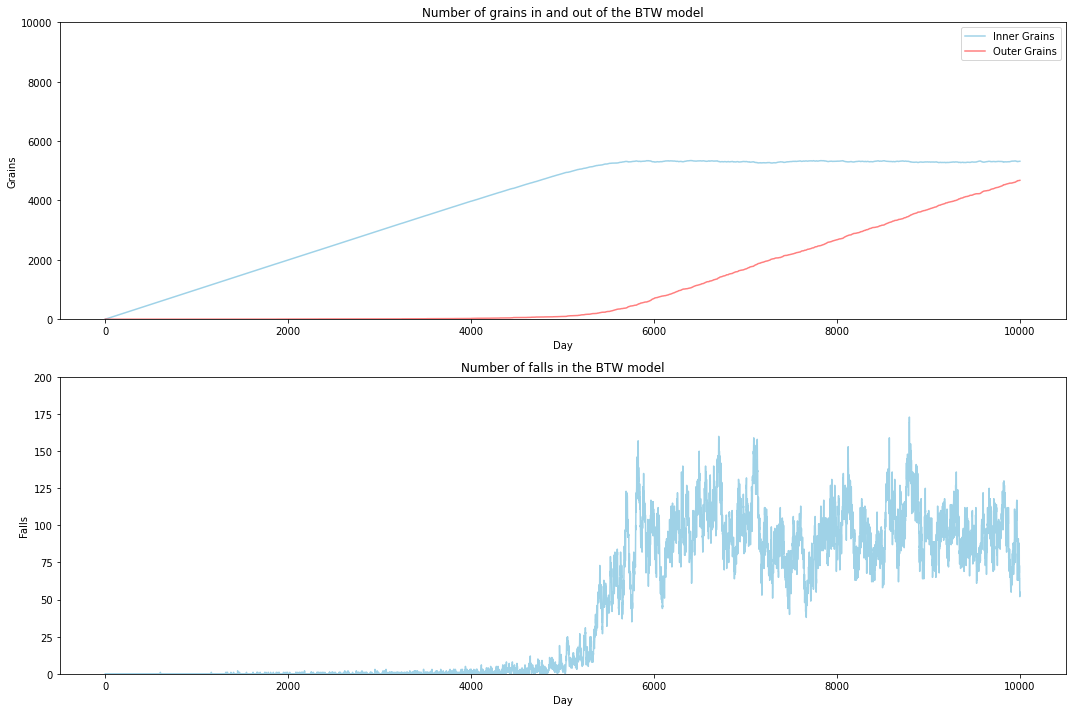

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains)

##### Additional Dissipation

100%|██████████| 10000/10000 [00:34<00:00, 286.85it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

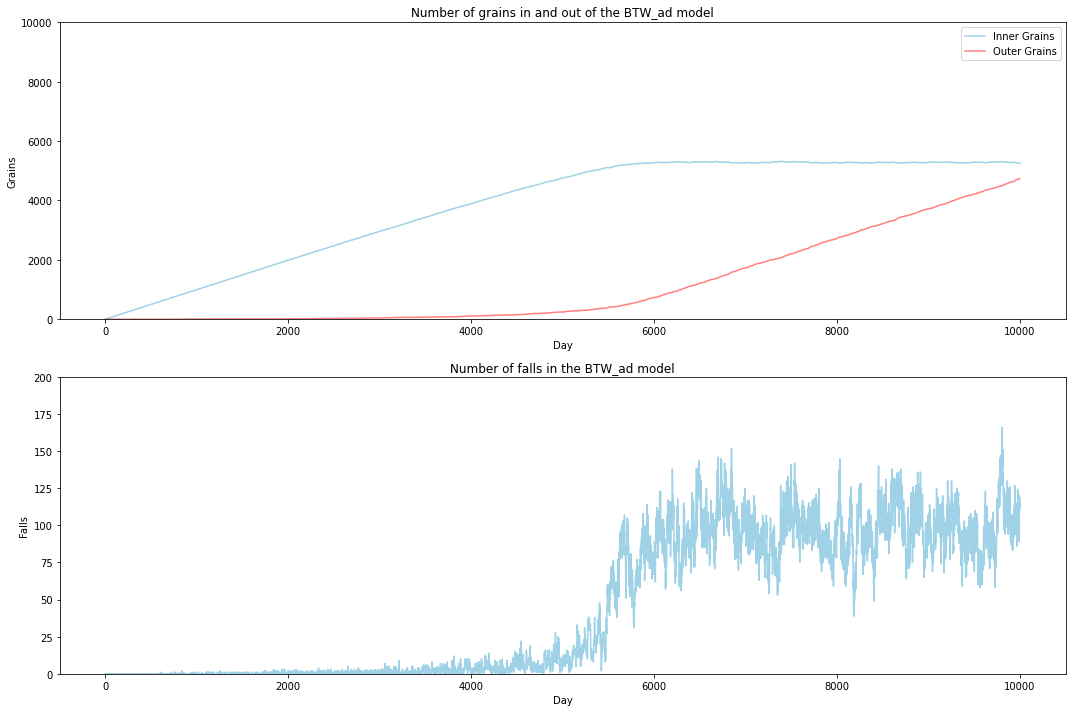

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

#### Facilitated Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:41<00:00, 240.78it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

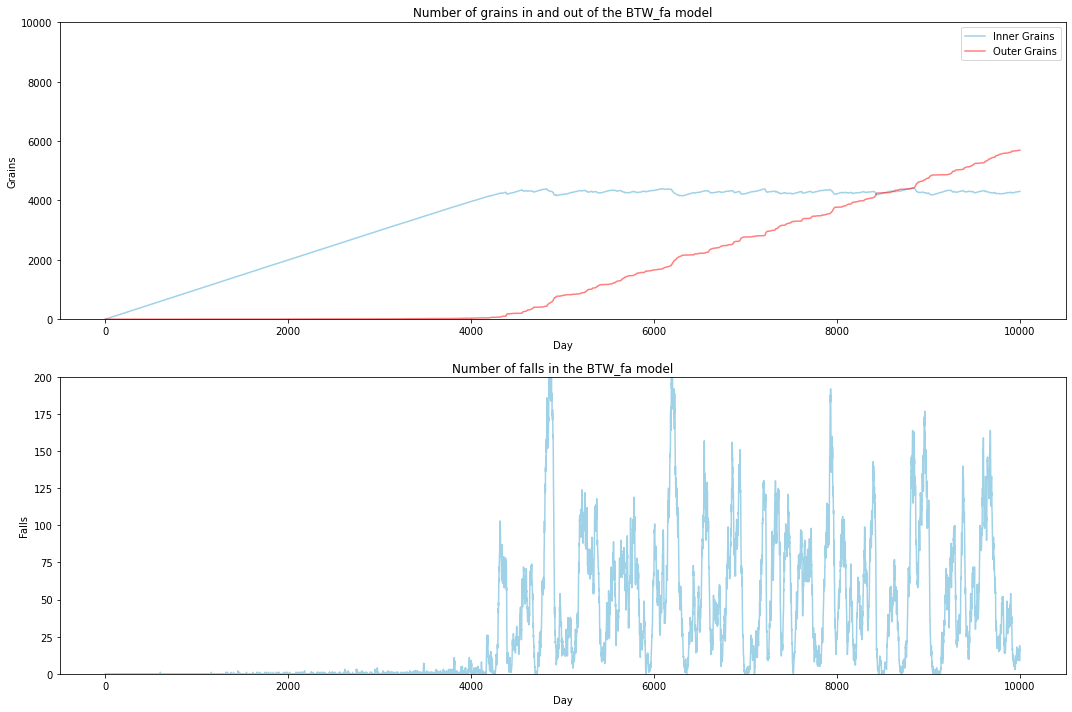

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains, facilitated = True)

##### Additional Dissipation

100%|██████████| 10000/10000 [00:38<00:00, 260.43it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

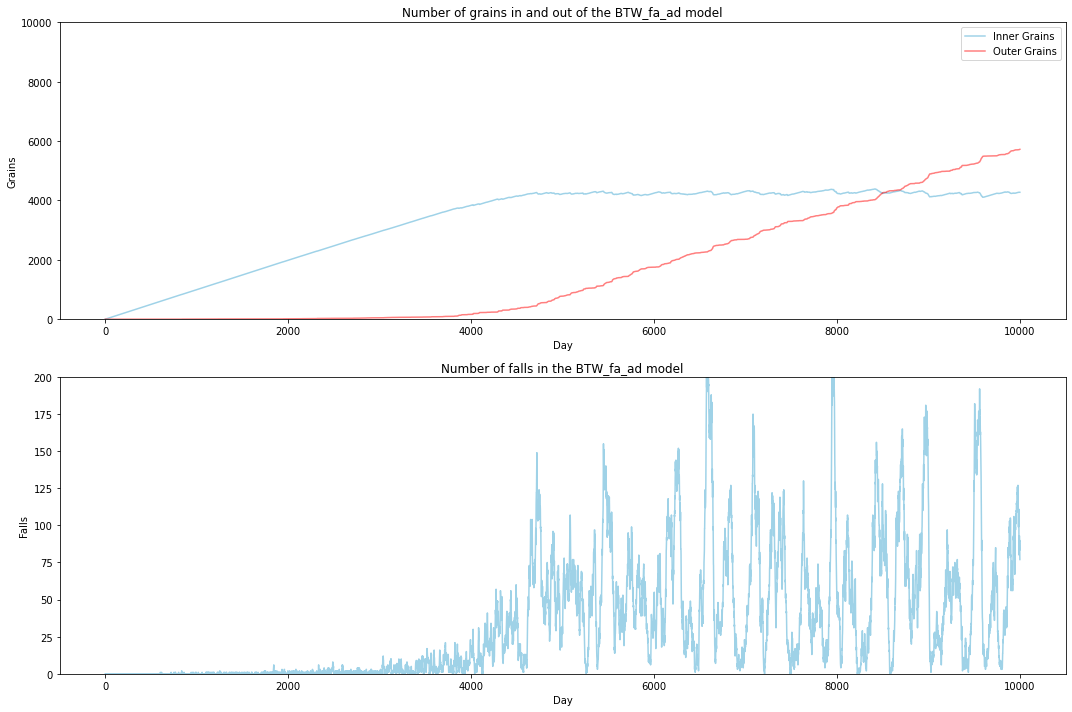

In [ ]:
spread("BTW", matrix_orig, number_of_days, new_grains, facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

### Mann

#### Standart Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:35<00:00, 283.19it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

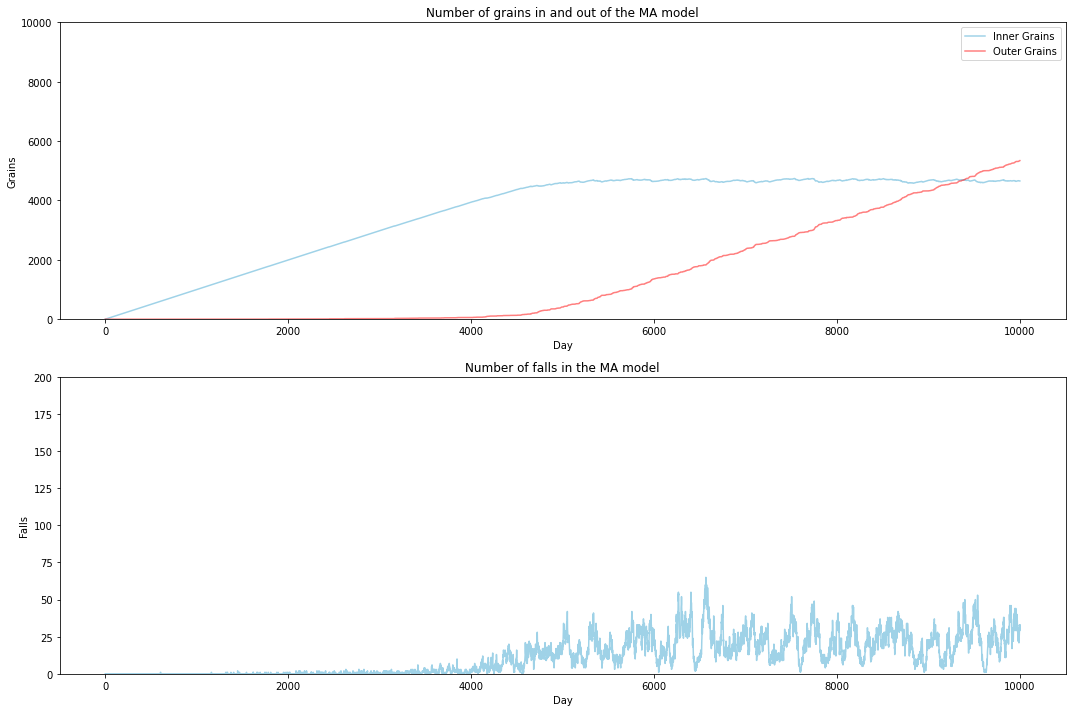

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains)

##### Additional Dissipation

100%|██████████| 10000/10000 [00:35<00:00, 283.01it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

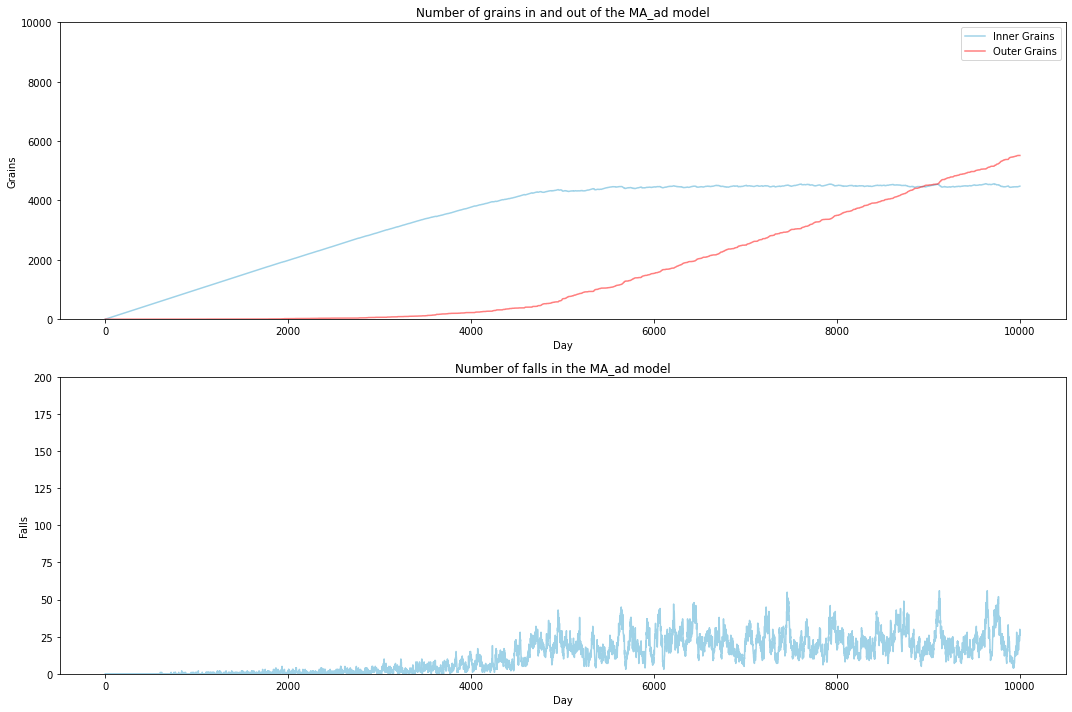

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

#### Facilitated Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:38<00:00, 262.58it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

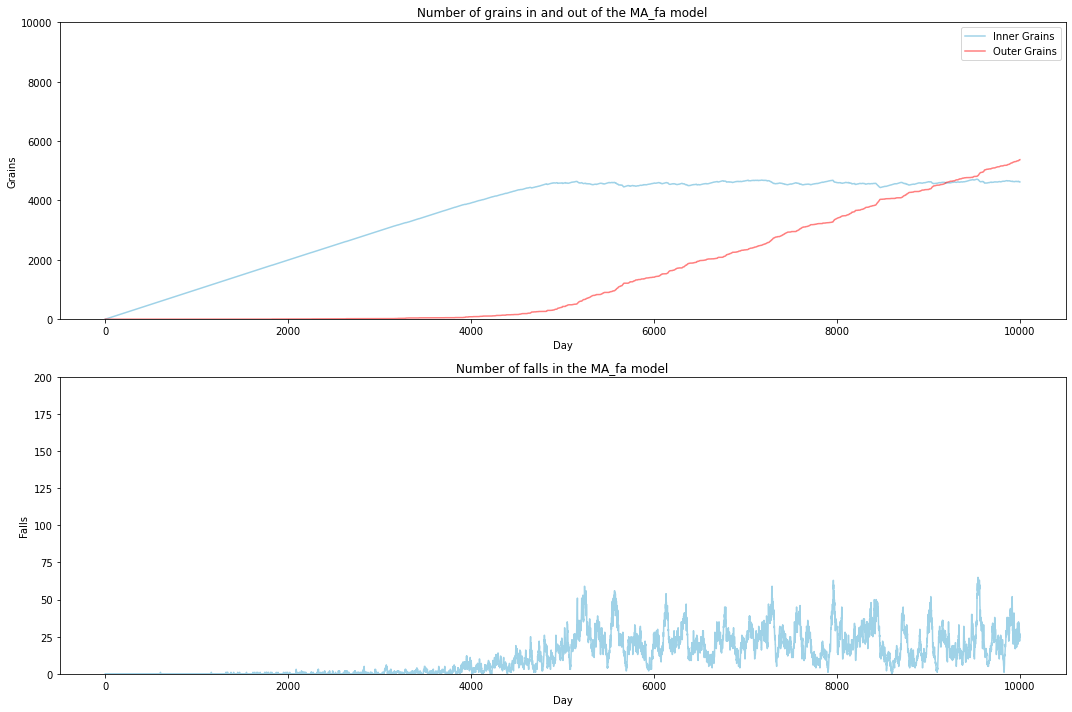

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains, facilitated = True)

##### Additional Dissipation

100%|██████████| 10000/10000 [00:40<00:00, 248.95it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

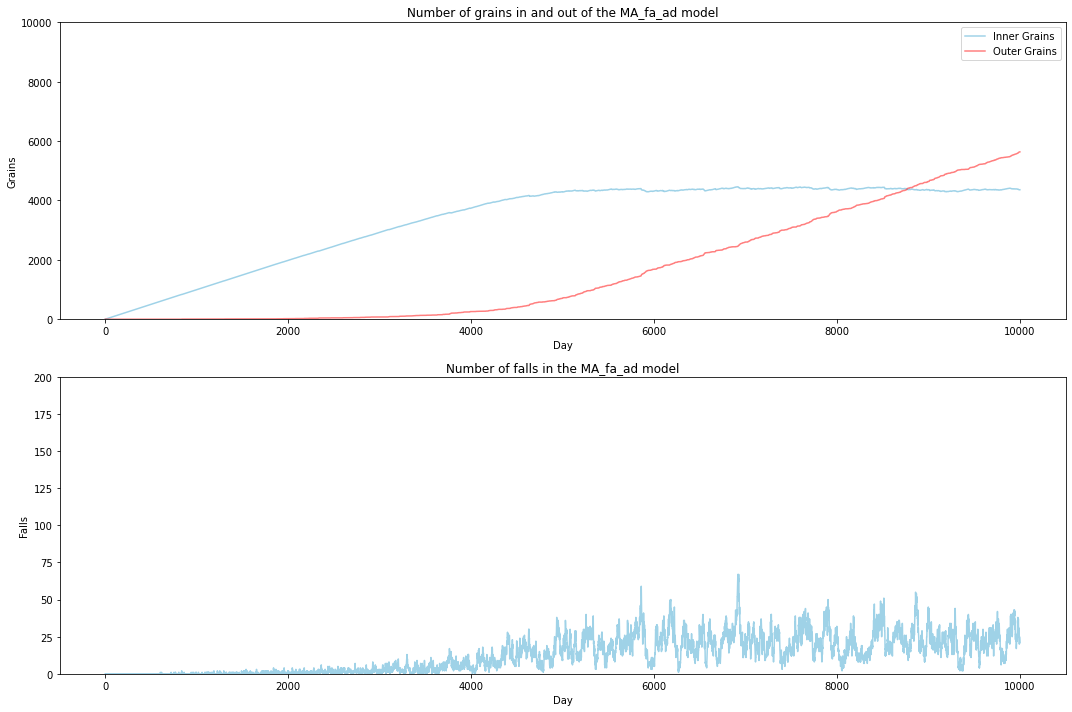

In [ ]:
spread("MA", matrix_orig, number_of_days, new_grains, facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

### Feder

#### Standart Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:34<00:00, 286.33it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

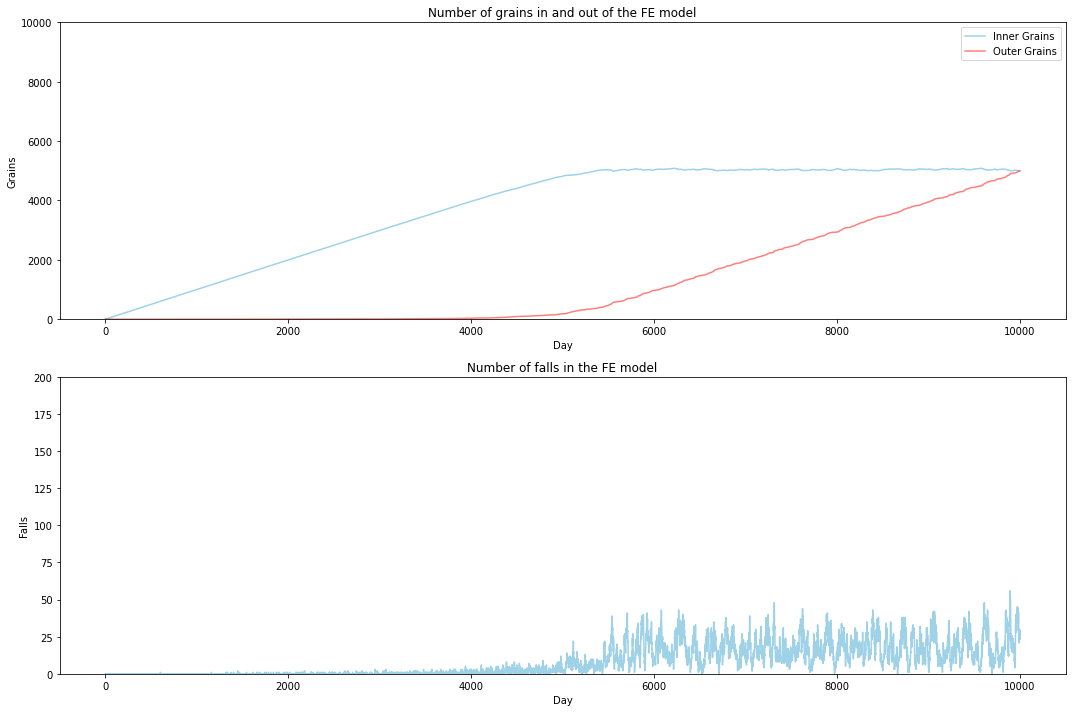

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains)

##### Additional Dissipation

100%|██████████| 10000/10000 [00:34<00:00, 287.82it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

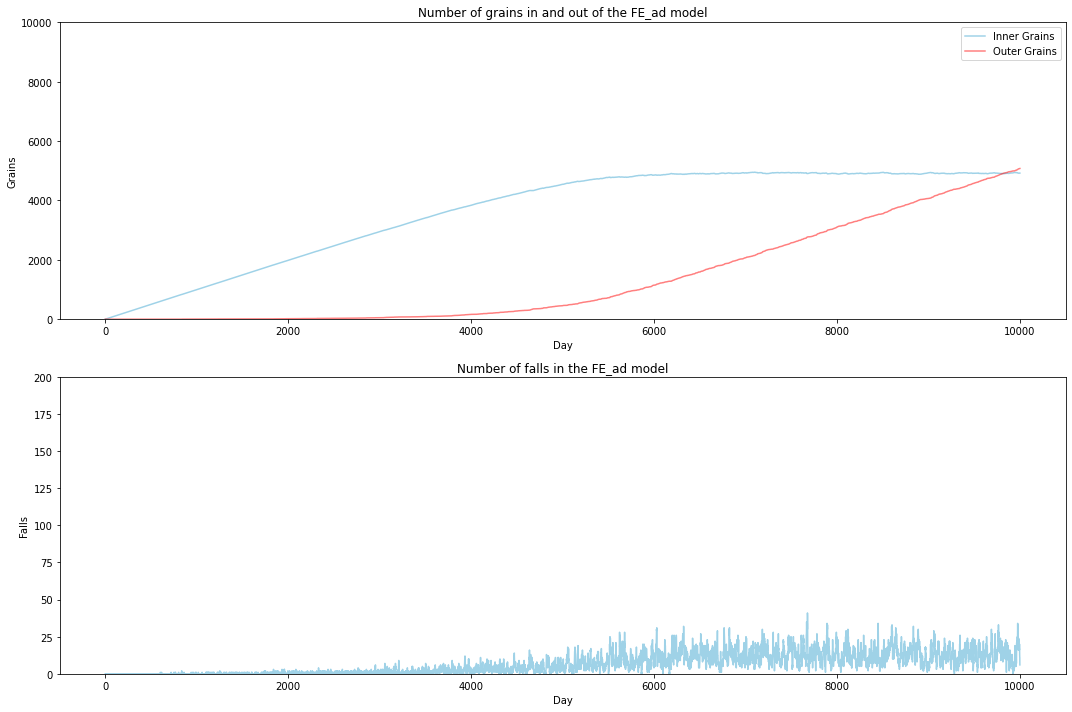

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

#### Facilitated Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:37<00:00, 269.15it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

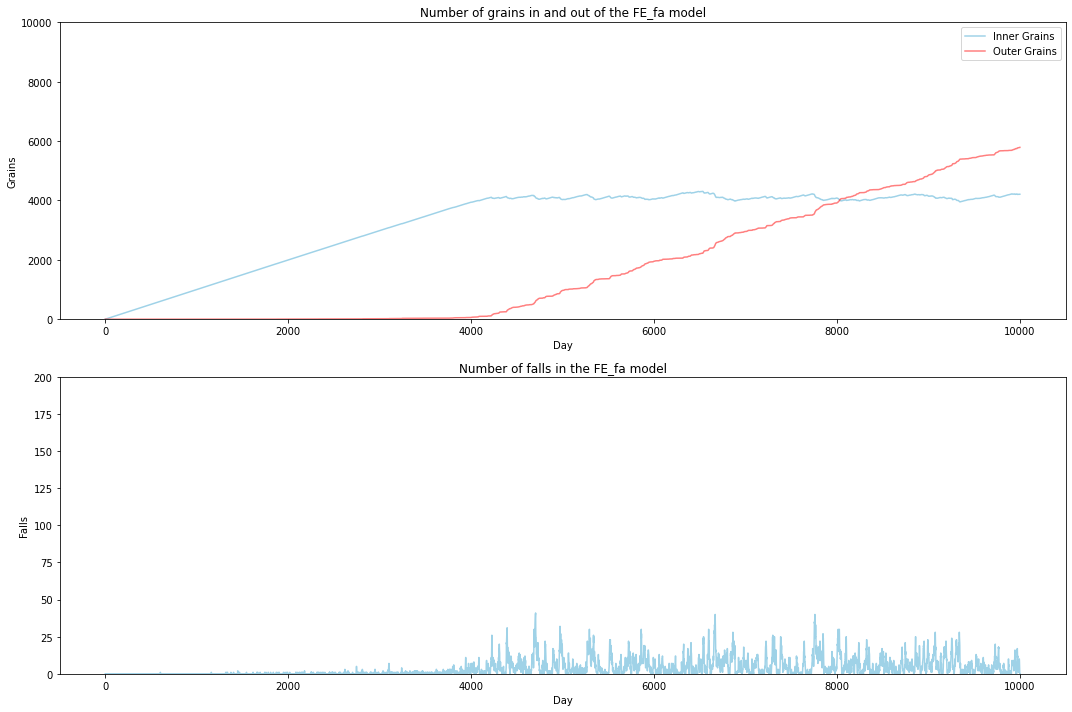

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains, facilitated = True)

##### Additional Dissipation

100%|██████████| 10000/10000 [00:37<00:00, 269.07it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

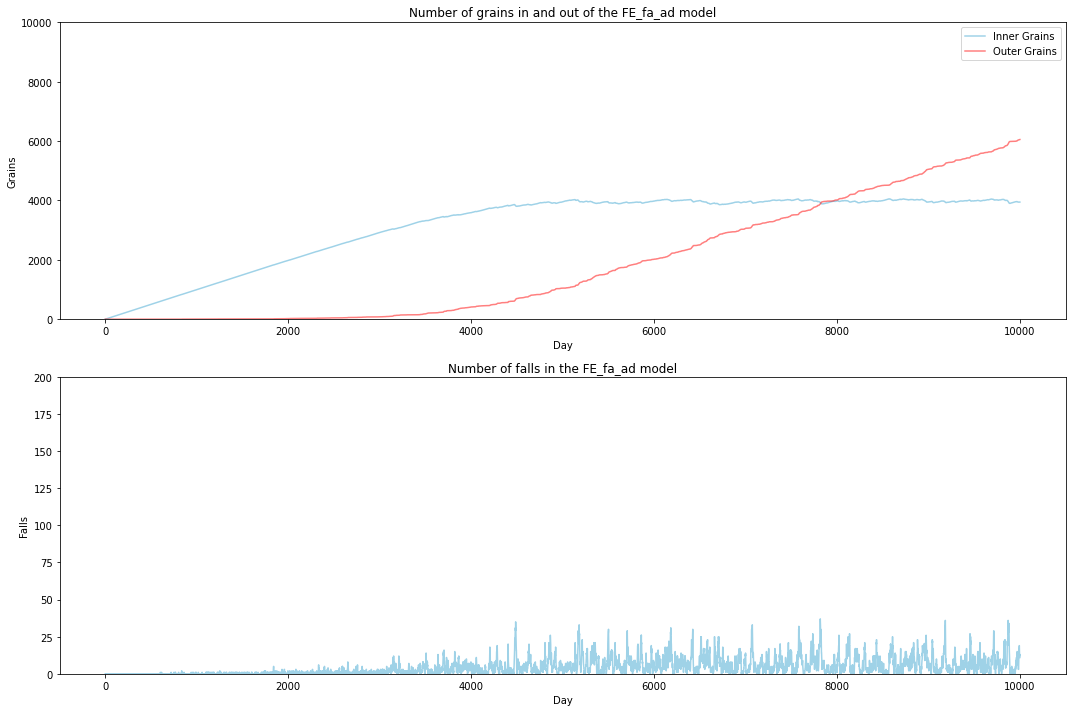

In [ ]:
spread("FE", matrix_orig, number_of_days, new_grains, facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

### Stochastic Feder

#### Standart Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:34<00:00, 289.58it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

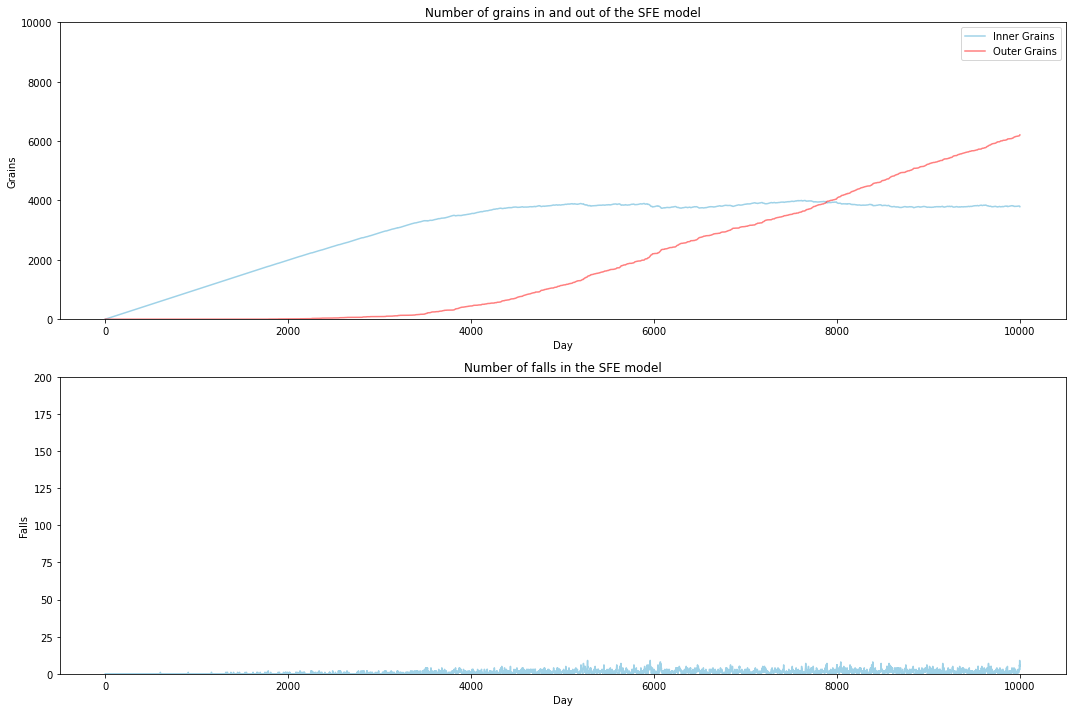

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains)

##### Additional Dissipation

100%|██████████| 10000/10000 [00:37<00:00, 269.49it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

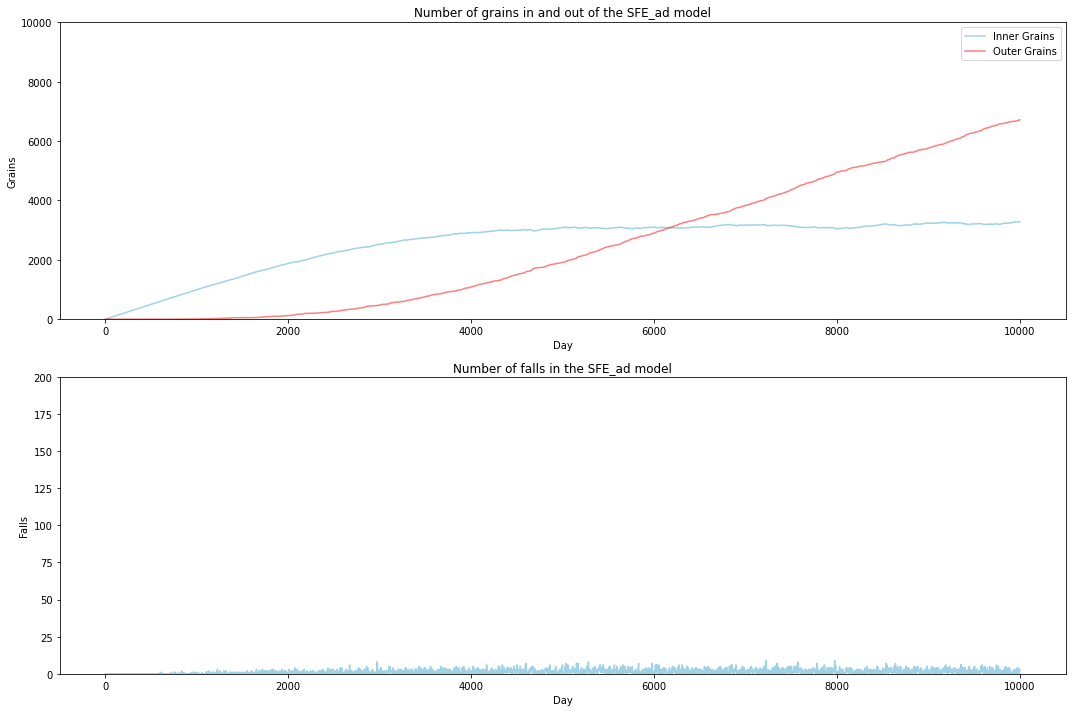

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

#### Facilitated Model

##### Standart dissipation

100%|██████████| 10000/10000 [00:37<00:00, 268.47it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

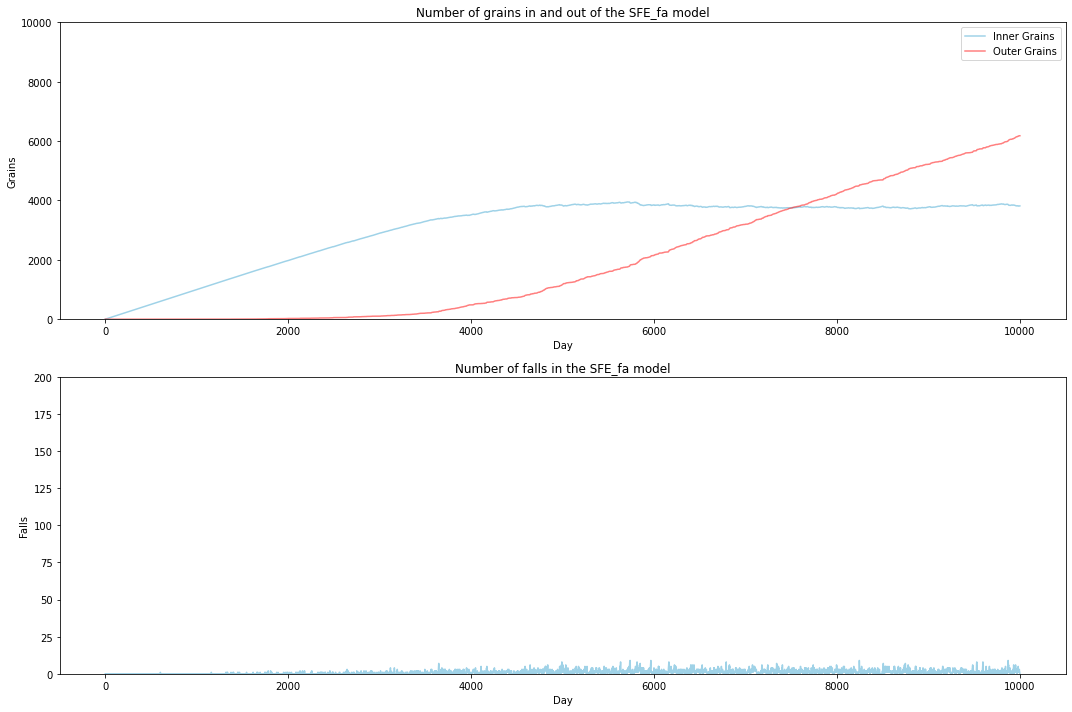

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains, facilitated = True)

##### Additional Dissipation

100%|██████████| 10000/10000 [00:38<00:00, 260.81it/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

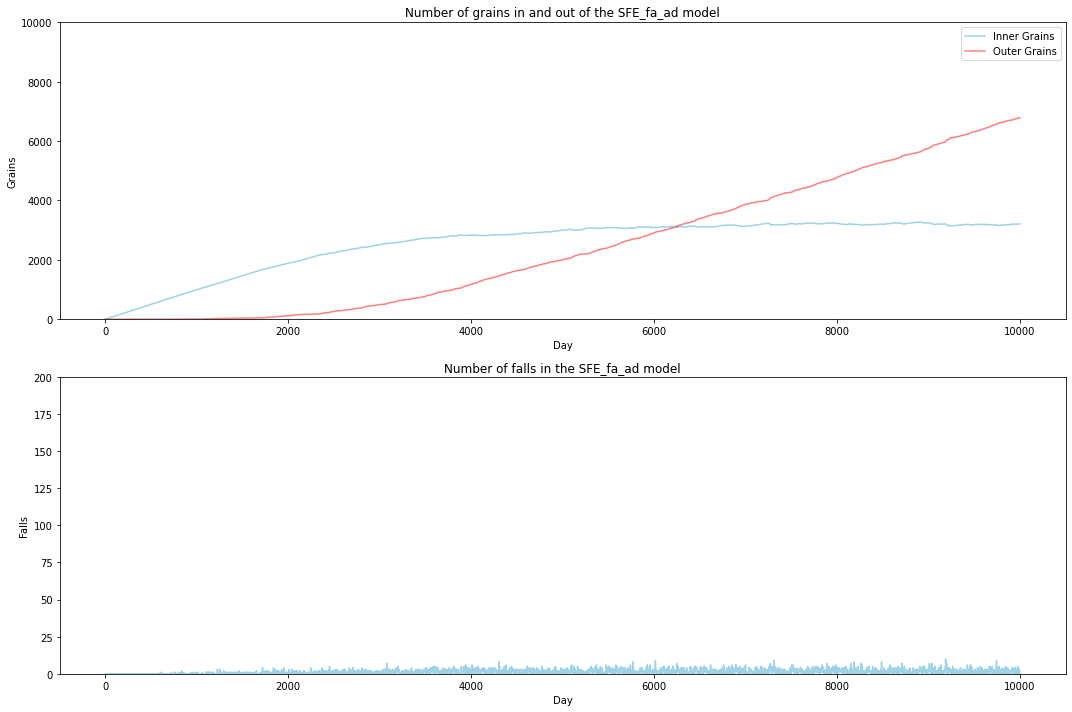

In [ ]:
spread("SFE", matrix_orig, number_of_days, new_grains, facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)